In [4]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from finance.utilities import utils, financial_utils, time_series_utils

# Options

In [5]:
query = """
    select *
    from td.options 
    where symbol = 'BA'
    """

options = utils.query_db(db_connection=utils.DW_STOCKS_JUPYTER, query=query)

In [6]:
options[options['description'].str.contains('BA Sep 20 2019')].T

,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720,...,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349
symbol,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA,...,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA
volatility,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
n_contracts,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,...,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782
interest_rate,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,...,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788
put_call,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,...,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL
description,BA Sep 20 2019 185 Call,BA Sep 20 2019 190 Call,BA Sep 20 2019 195 Call,BA Sep 20 2019 200 Call,BA Sep 20 2019 205 Call,BA Sep 20 2019 210 Call,BA Sep 20 2019 215 Call,BA Sep 20 2019 220 Call,BA Sep 20 2019 225 Call,BA Sep 20 2019 230 Call,...,BA Sep 20 2019 397.5 Call,BA Sep 20 2019 400 Call,BA Sep 20 2019 402.5 Call,BA Sep 20 2019 405 Call,BA Sep 20 2019 407.5 Call,BA Sep 20 2019 410 Call,BA Sep 20 2019 412.5 Call,BA Sep 20 2019 415 Call,BA Sep 20 2019 417.5 Call,BA Sep 20 2019 420 Call
exchange_name,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,...,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR
bid,199.25,194.25,189.25,184.25,179.25,174.25,169.25,164.25,159.3,154.3,...,0.01,0.04,0,0,0,0,0,0.01,0,0
ask,199.9,194.9,189.9,184.9,179.9,174.9,169.95,164.95,159.95,154.95,...,0.11,0.05,0.04,0.03,0.03,0.04,0.02,0.02,0.01,0.01
last,192.95,170.65,163.85,176.85,175.95,169.8,148.7,140.7,155.05,101.71,...,0.07,0.04,0.03,0.02,0.03,0.03,0.08,0.01,0.02,0.02


### Black scholes

In [7]:
option = financial_utils.BlackScholes(
    current_stock_price=450,
    strike_price=385,
    risk_free_rate=1.025,
    days_to_maturity=60,
    volatility=.5,
    call_put='call'
)

In [8]:
print('Theoretical option price: $' + str(round(option.option_price, 2)))

Theoretical option price: $76.84


### Greeks

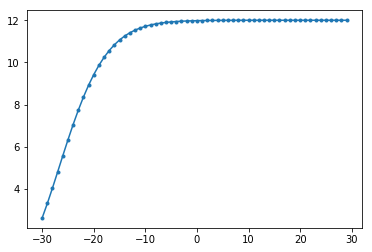

In [9]:
deltas = option.get_greek(greek='delta', steps=30)
plt.plot(deltas, marker='.')
plt.show()

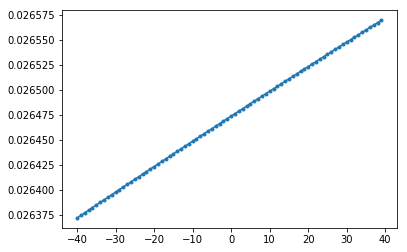

In [10]:
ros = option.get_greek(greek='ro', steps=40)
plt.plot(ros, marker='.')
plt.show()

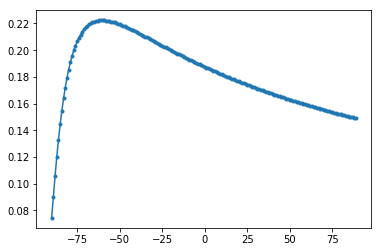

In [11]:
thetas = option.get_greek('theta', steps=90)
plt.plot(thetas, marker='.')
plt.show()

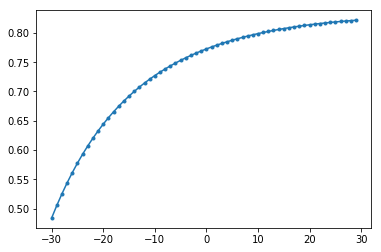

In [12]:
vegas = option.get_greek(greek='vega', steps=30)
plt.plot(vegas, marker='.')
plt.show()

In [13]:
chain = options[options['description'].str.contains('BA Sep 20 2019')]
chain = options[(options['description'].str.contains('BA Sep 20 2019')) & (options['put_call']=='CALL')]

In [14]:
chain.head(1).T

,1711
symbol,BA
volatility,29
n_contracts,1782
interest_rate,2.42788
put_call,CALL
description,BA Sep 20 2019 185 Call
exchange_name,OPR
bid,199.25
ask,199.9
last,192.95


### Implied volatility

In [27]:
options['days_to_expiration'].unique()

array([  6.,  13.,  20.,  27., 237.,  34.,  41.,  55.,  90., 118., 153.,
       181., 272., 363., 853., 482., 183.,   1.,   8.,  15.,  22.,  29.,
        36.,  43.,  57., 120., 155., 274., 365., 484., 855.])

In [31]:
imp_vols = []
current_stock_price = 354.42
risk_free_rate=1.025
volatility=.5
opts = options[(options['days_to_expiration']==55) 
               & (options['put_call'].str.lower()=='call') 
               & (options['total_volume']>0)]
for idw, row in opts.iterrows():
    imp_vol = financial_utils.BlackScholes(
        current_option_price=row['close_price'],
        current_stock_price=current_stock_price,
        strike_price=row['strike'],
        risk_free_rate=risk_free_rate,
        days_to_maturity=row['days_to_expiration_date'],
        volatility=volatility,
        call_put=row['put_call'].lower()
    ).implied_volatility
    imp_vols.append(imp_vol)


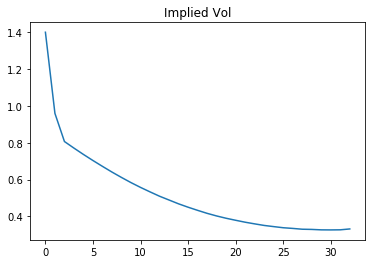

In [33]:
imp_vols = pd.DataFrame(imp_vols)
plt.figure()
plt.title('Implied Vol')
plt.plot(imp_vols)
plt.show()